In [1]:
import numpy as np 
import pandas as pd
import os
import PIL
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
from skimage.transform import resize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
xTrain=[]
yTrain=[]
Datafr=pd.DataFrame(columns=['feature'])
df=pd.DataFrame(columns=['feature'])
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/training/ISIC-2017_Training_Data'):
  continue
xTrain= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((256,256)))for filename in sorted(filenames)])

#df=pd.DataFrame(data = [[x.flatten()] for x in xTrain])
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/training/ISIC-2017_Training_Part1_GroundTruth'):
  continue
yTrain= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((256,256)))for filename in sorted(filenames)])
               

In [4]:
xValid=[]
yValid=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/validation/ISIC-2017_Validation_Data'):
  continue;
xValid= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((256,256)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/validation/ISIC-2017_Validation_Part1_GroundTruth'):
  continue;
yValid= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((256,256)))for filename in sorted(filenames)])
               

In [5]:
xTest=[]
yTest=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/test/ISIC-2017_Test_v2_Data'):
  continue;
xTest= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((256,256)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/test/ISIC-2017_Test_v2_Part1_GroundTruth'):
  continue;
yTest= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((256,256)))for filename in sorted(filenames)])
               

**Data Augmentation**

In [ ]:


def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image.astype('float32'),M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def flip_image(x_image,y_image):
  
    x_image = cv2.flip(x_image.astype('float32'),0)
    y_image = cv2.flip(y_image.astype('float32'),0)
    return x_image, y_image.astype('int')


def img_augmentation(xTrain, yTrain):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(200):
        x,y = random_rotation(xTrain[idx], yTrain[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = flip_image(xTrain[idx], yTrain[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)



x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(xTrain, yTrain)



In [ ]:

x_train_full = np.concatenate([xTrain, x_rotated, x_flipped])
y_train_full = np.concatenate([yTrain, y_rotated, y_flipped])
x_train_full.dtype
xTrain=x_train_full
yTrain=y_train_full

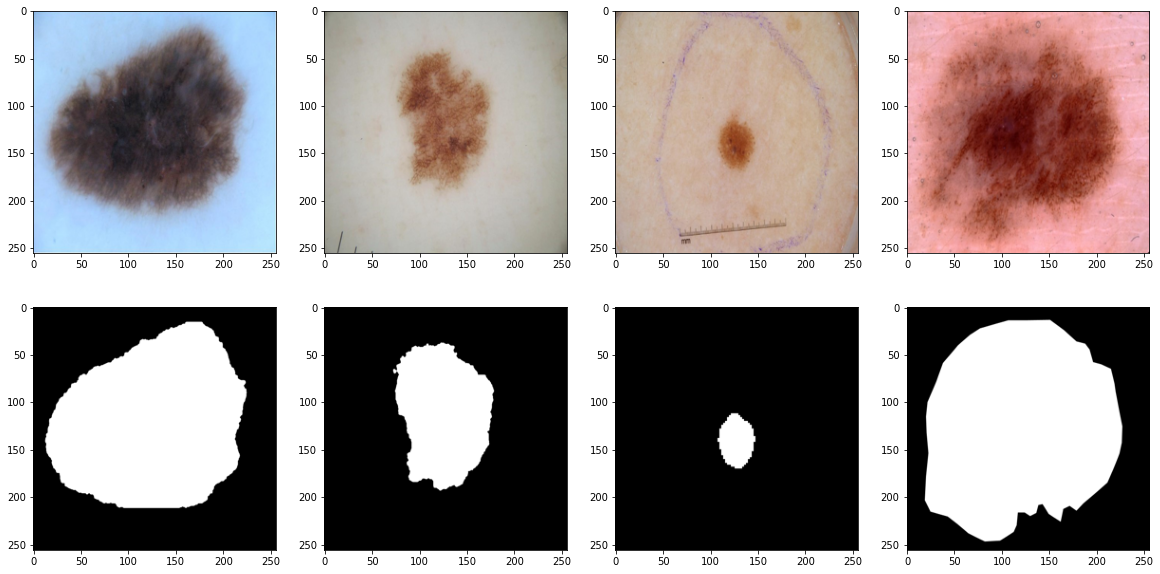

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.imshow(xTrain[0])
plt.subplot(2,4,2)
plt.imshow(xTrain[600])
plt.subplot(2,4,3)
plt.imshow(xTrain[1200])
plt.subplot(2,4,4)
plt.imshow(xTrain[1900])
plt.subplot(2,4,5)
plt.imshow(yTrain[0],cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(yTrain[600],cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(yTrain[1200],cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(yTrain[1900],cmap = plt.cm.binary_r)

In [6]:
for i in range(len(yTrain)):
  ret,yTrain[i]=cv2.threshold(yTrain[i],127,1,cv2.THRESH_BINARY)
for j in range(len(yValid)):  
  ret,yValid[j]=cv2.threshold(yValid[j],127,1,cv2.THRESH_BINARY)
for k in range(len(yTest)):
  ret,yTest[k]=cv2.threshold(yTest[k],127,1,cv2.THRESH_BINARY)

In [7]:

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)    
        

In [ ]:
print(xTrain.dtype)
print(yValid.dtype)
xTrain[1].shape

float32
float32


(480, 640, 3)

In [8]:
xTrain=xTrain.astype('float16')
yTrain=yTrain.astype('float16')
xValid=xValid.astype('float16')
yValid=yValid.astype('float16')
xTest=xTest.astype('float16')
yTest=yTest.astype('float16')

In [23]:
def fcn_net(epochs_num,learningRate):
    img_input = Input(shape= xTrain[1].shape)
    #C1############################
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='conv1',strides= (1,1))(img_input)
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='conv1-2',strides= (1,1))(img_input)
    x = MaxPooling2D()(x)
    #C2############################
    x = Conv2D(128, (3, 3),activation='relu', padding='same', name='conv2')(x)
    x = Conv2D(128, (3, 3),activation='relu', padding='same', name='conv2-2')(x)
    x = MaxPooling2D()(x)
    #C3############################
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3-2')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3-3')(x)
    x = MaxPooling2D()(x)
    #C4############################
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4-2')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4-3')(x)
    x = MaxPooling2D()(x)
    #C5############################
    x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5')(x)
    x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5-2')(x)
    x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5-3')(x)
    x = MaxPooling2D()(x)
    #LAST THREE LAYERS
    x = Conv2D(512, (1, 1),activation='relu', padding='same', name='1d-1')(x)
    x = Conv2D(512, (1, 1),activation='relu', padding='same', name='1d-2')(x)
    x = Conv2D(2, (1, 1), activation = 'relu',padding='same', name='1d-3')(x)
    
    # Deconvolution Layers )
    x = Conv2DTranspose(1, (3, 3),strides = (32,32),activation='sigmoid', padding='same', name='deconv4')(x)
    pred = Reshape( yTrain[1].shape)(x)
    model = Model(inputs=img_input, outputs=pred)
    model.compile(optimizer= Adam(learning_rate = learningRate), loss= [jaccard_distance]
                  , metrics=[iou])
    hist = model.fit(xTrain, yTrain, epochs= epochs_num, validation_data= (xValid, yValid), verbose=1)
    return model,hist

In [24]:
def fcn_net_mul_deconv(epochs_num,learningRate):

    # Convolution Layers 
    img_input = Input(shape= xTrain[1].shape)
    #C1#################################
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='conv1',strides= (1,1))(img_input)
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='conv1-2',strides= (1,1))(img_input)
    x = MaxPooling2D()(x)
    #C2#################################
    x = Conv2D(128, (3, 3),activation='relu', padding='same', name='conv2')(x)
    x = Conv2D(128, (3, 3),activation='relu', padding='same', name='conv2-2')(x)
    x = MaxPooling2D()(x)
    #C3############################
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3-2')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3-3')(x)
    x = MaxPooling2D()(x)
    #C4############################
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4-2')(x)
    x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4-3')(x)
    x = MaxPooling2D()(x)
    #C5############################
    x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5')(x)
    x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5-2')(x)
    x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5-3')(x)
    x = MaxPooling2D()(x)
    #LAST THREE LAYERS
    x = Conv2D(512, (1, 1),activation='relu', padding='same', name='1d-1')(x)
    x = Conv2D(512, (1, 1),activation='relu', padding='same', name='1d-2')(x)
    x = Conv2D(2, (1, 1),activation='relu', padding='same', name='1d-3')(x)

    # Deconvolution Layers (BatchNorm after non-linear activation)
    x = Conv2DTranspose(1, (3, 3),strides=(2,2), activation = 'relu',padding='same', name='deconv1')(x)

    x = Conv2DTranspose(1, (3, 3),strides=(2,2), activation = 'relu',padding='same', name='deconv2')(x)

    x = Conv2DTranspose(1, (3, 3),strides=(2,2), activation = 'relu',padding='same', name='deconv3')(x)

    x = Conv2DTranspose(1, (3, 3),strides=(4,4),activation='sigmoid', padding='same', name='deconv4')(x)
    pred = Reshape( yTrain[1].shape)(x)
    model = Model(inputs=img_input, outputs=pred)
    model.compile(optimizer= Adam(learning_rate = learningRate), loss= [jaccard_distance]
                  , metrics=[iou])
    
    hist = model.fit(xTrain, yTrain, epochs= epochs_num, validation_data= (xValid, yValid), verbose=1)
    

    
    return model,hist

In [25]:
modelDeconv ,histDeconv = fcn_net_mul_deconv(epochs_num= 10 ,learningRate = 0.001 )

Epoch 1/10
63/63 [==============================] - 45s 689ms/step - loss: 0.3399 - iou: 0.6601 - val_loss: 0.3364 - val_iou: 0.6636
Epoch 2/10
63/63 [==============================] - 42s 673ms/step - loss: 0.3255 - iou: 0.6745 - val_loss: 0.3221 - val_iou: 0.6779
Epoch 3/10
63/63 [==============================] - 42s 669ms/step - loss: 0.3109 - iou: 0.6891 - val_loss: 0.3063 - val_iou: 0.6937
Epoch 4/10
63/63 [==============================] - 42s 667ms/step - loss: 0.2963 - iou: 0.7037 - val_loss: 0.2876 - val_iou: 0.7124
Epoch 5/10
63/63 [==============================] - 42s 666ms/step - loss: 0.2726 - iou: 0.7274 - val_loss: 0.2532 - val_iou: 0.7468
Epoch 6/10
63/63 [==============================] - 42s 660ms/step - loss: 0.2696 - iou: 0.7304 - val_loss: 0.2680 - val_iou: 0.7320
Epoch 7/10
63/63 [==============================] - 41s 653ms/step - loss: 0.2761 - iou: 0.7239 - val_loss: 0.2770 - val_iou: 0.7230
Epoch 8/10
63/63 [==============================] - 41s 656ms/step - 

In [ ]:
modelDeconv ,histDeconv = fcn_net_mul_deconv(epochs_num= 10 ,learningRate = 0.001 )

Epoch 1/10
63/63 [==============================] - 43s 652ms/step - loss: 0.3431 - iou: 0.6569 - accuracy: 0.8052 - val_loss: 0.3431 - val_iou: 0.6569 - val_accuracy: 0.8098
Epoch 2/10
63/63 [==============================] - 41s 644ms/step - loss: 0.3350 - iou: 0.6650 - accuracy: 0.8062 - val_loss: 0.3343 - val_iou: 0.6657 - val_accuracy: 0.8098
Epoch 3/10
63/63 [==============================] - 41s 646ms/step - loss: 0.3271 - iou: 0.6729 - accuracy: 0.8063 - val_loss: 0.3256 - val_iou: 0.6744 - val_accuracy: 0.8098
Epoch 4/10
63/63 [==============================] - 41s 646ms/step - loss: 0.3193 - iou: 0.6807 - accuracy: 0.8052 - val_loss: 0.3170 - val_iou: 0.6830 - val_accuracy: 0.8098
Epoch 5/10
63/63 [==============================] - 41s 649ms/step - loss: 0.3118 - iou: 0.6882 - accuracy: 0.8067 - val_loss: 0.3087 - val_iou: 0.6913 - val_accuracy: 0.8098
Epoch 6/10
63/63 [==============================] - 41s 647ms/step - loss: 0.3044 - iou: 0.6956 - accuracy: 0.8064 - val_loss

In [ ]:
modelDeconv ,histDeconv = fcn_net_mul_deconv(epochs_num= 10 ,learningRate = 0.005 )

Epoch 1/10
63/63 [==============================] - 43s 655ms/step - loss: 0.3278 - iou: 0.6722 - accuracy: 0.8062 - val_loss: 0.3087 - val_iou: 0.6913 - val_accuracy: 0.8098
Epoch 2/10
63/63 [==============================] - 41s 645ms/step - loss: 0.2909 - iou: 0.7091 - accuracy: 0.8060 - val_loss: 0.2709 - val_iou: 0.7291 - val_accuracy: 0.8098
Epoch 3/10
63/63 [==============================] - 41s 647ms/step - loss: 0.2624 - iou: 0.7376 - accuracy: 0.8067 - val_loss: 0.2432 - val_iou: 0.7568 - val_accuracy: 0.8098
Epoch 4/10
63/63 [==============================] - 41s 646ms/step - loss: 0.2429 - iou: 0.7571 - accuracy: 0.8064 - val_loss: 0.2244 - val_iou: 0.7756 - val_accuracy: 0.8098
Epoch 5/10
63/63 [==============================] - 41s 647ms/step - loss: 0.2306 - iou: 0.7694 - accuracy: 0.8057 - val_loss: 0.2128 - val_iou: 0.7872 - val_accuracy: 0.8098
Epoch 6/10
63/63 [==============================] - 41s 647ms/step - loss: 0.2232 - iou: 0.7768 - accuracy: 0.8065 - val_loss

In [ ]:
modelDeconv ,histDeconv = fcn_net_mul_deconv(epochs_num= 50 ,learningRate = 0.003 )

Epoch 1/50
63/63 [==============================] - 72s 820ms/step - loss: 0.3343 - iou: 0.6657 - accuracy: 0.8049 - val_loss: 0.3216 - val_iou: 0.6784 - val_accuracy: 0.8098
Epoch 2/50
63/63 [==============================] - 40s 638ms/step - loss: 0.3034 - iou: 0.6966 - accuracy: 0.8059 - val_loss: 0.2839 - val_iou: 0.7161 - val_accuracy: 0.8098
Epoch 3/50
63/63 [==============================] - 40s 643ms/step - loss: 0.2719 - iou: 0.7281 - accuracy: 0.8065 - val_loss: 0.2519 - val_iou: 0.7481 - val_accuracy: 0.8098
Epoch 4/50
63/63 [==============================] - 41s 643ms/step - loss: 0.2505 - iou: 0.7495 - accuracy: 0.8068 - val_loss: 0.2329 - val_iou: 0.7671 - val_accuracy: 0.8098
Epoch 5/50
63/63 [==============================] - 41s 644ms/step - loss: 0.2393 - iou: 0.7607 - accuracy: 0.8064 - val_loss: 0.2227 - val_iou: 0.7773 - val_accuracy: 0.8098
Epoch 6/50
63/63 [==============================] - 41s 644ms/step - loss: 0.2331 - iou: 0.7669 - accuracy: 0.8060 - val_loss

In [ ]:
model, hist = fcn_net(epochs_num= 1 ,learningRate = 0.001 )

63/63 [==============================] - 43s 650ms/step - loss: 0.3356 - iou: 0.6644 - accuracy: 0.8065 - val_loss: 0.3260 - val_iou: 0.6740 - val_accuracy: 0.8098


In [ ]:
model, hist = fcn_net(epochs_num= 50 ,learningRate = 0.005)

Epoch 1/50
63/63 [==============================] - 66s 819ms/step - loss: 0.3280 - iou: 0.6720 - val_loss: 0.3090 - val_iou: 0.6910
Epoch 2/50
63/63 [==============================] - 40s 638ms/step - loss: 0.2914 - iou: 0.7086 - val_loss: 0.2713 - val_iou: 0.7287
Epoch 3/50
63/63 [==============================] - 41s 644ms/step - loss: 0.2627 - iou: 0.7373 - val_loss: 0.2434 - val_iou: 0.7566
Epoch 4/50
63/63 [==============================] - 40s 640ms/step - loss: 0.2430 - iou: 0.7570 - val_loss: 0.2246 - val_iou: 0.7754
Epoch 5/50
63/63 [==============================] - 41s 644ms/step - loss: 0.2307 - iou: 0.7693 - val_loss: 0.2128 - val_iou: 0.7872
Epoch 6/50
63/63 [==============================] - 41s 644ms/step - loss: 0.2232 - iou: 0.7768 - val_loss: 0.2052 - val_iou: 0.7948
Epoch 7/50
63/63 [==============================] - 41s 644ms/step - loss: 0.2187 - iou: 0.7813 - val_loss: 0.2005 - val_iou: 0.7995
Epoch 8/50
63/63 [==============================] - 41s 645ms/step - 

In [26]:
img_input = Input(shape= xTrain[1].shape)
#C1############################
x = Conv2D(64, (3, 3),activation='relu', padding='same', name='conv1',strides= (1,1))(img_input)
x = Conv2D(64, (3, 3),activation='relu', padding='same', name='conv1-2',strides= (1,1))(img_input)
x = MaxPooling2D()(x)
    #C2############################
x = Conv2D(128, (3, 3),activation='relu', padding='same', name='conv2')(x)
x = Conv2D(128, (3, 3),activation='relu', padding='same', name='conv2-2')(x)
x = MaxPooling2D()(x)
    #C3############################
x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3')(x)
x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3-2')(x)
x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv3-3')(x)
x = MaxPooling2D()(x)
    #C4############################
x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4')(x)
x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4-2')(x)
x = Conv2D(256, (3, 3),activation='relu', padding='same', name='conv4-3')(x)
x = MaxPooling2D()(x)
    #C5############################
x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5')(x)
x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5-2')(x)
x = Conv2D(512, (3, 3),activation='relu', padding='same', name='conv5-3')(x)
x = MaxPooling2D()(x)
    #LAST THREE LAYERS
x = Conv2D(512, (1, 1),activation='relu', padding='same', name='1d-1')(x)
x = Conv2D(512, (1, 1),activation='relu', padding='same', name='1d-2')(x)
x = Conv2D(2, (1, 1), activation = 'relu',padding='same', name='1d-3')(x)
    
    # Deconvolution Layers )
x = Conv2DTranspose(1, (3, 3),strides = (32,32),activation='sigmoid', padding='same', name='deconv4')(x)
pred = Reshape( yTrain[1].shape)(x)
fcn = Model(inputs=img_input, outputs=pred)
fcn.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance], metrics=[iou])
hist = fcn.fit(xTrain, yTrain, epochs= 50, validation_data= (xValid, yValid), verbose=1)

Epoch 1/50
63/63 [==============================] - 23s 354ms/step - loss: 0.3355 - iou: 0.6645 - val_loss: 0.3258 - val_iou: 0.6742
Epoch 2/50
63/63 [==============================] - 22s 343ms/step - loss: 0.3122 - iou: 0.6878 - val_loss: 0.3007 - val_iou: 0.6993
Epoch 3/50
63/63 [==============================] - 22s 352ms/step - loss: 0.2910 - iou: 0.7090 - val_loss: 0.2783 - val_iou: 0.7217
Epoch 4/50
63/63 [==============================] - 22s 345ms/step - loss: 0.2728 - iou: 0.7272 - val_loss: 0.2592 - val_iou: 0.7408
Epoch 5/50
63/63 [==============================] - 22s 343ms/step - loss: 0.2580 - iou: 0.7420 - val_loss: 0.2438 - val_iou: 0.7562
Epoch 6/50
63/63 [==============================] - 22s 346ms/step - loss: 0.2463 - iou: 0.7537 - val_loss: 0.2315 - val_iou: 0.7685
Epoch 7/50
63/63 [==============================] - 22s 349ms/step - loss: 0.2374 - iou: 0.7626 - val_loss: 0.2222 - val_iou: 0.7778
Epoch 8/50
63/63 [==============================] - 22s 348ms/step - 

In [30]:
res = fcn.evaluate(xTest, yTest, batch_size= 32)
print('FCN')
print('IOU:       |   {:.2f}  | '.format(res[1]*100))
print("Loss:      |   {:.2f}  | ".format(res[0]*100))

34/34 [==============================] - 7s 116ms/step - loss: 0.2413 - iou: 0.7587
FCN
IOU:       |   75.87  | 
Loss:      |   24.13  | 


In [31]:
baseModel = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape = (256,256,3),
    include_top=False
)
baseModel.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [32]:
from keras.engine import training


input_image=tf. keras.layers.Input((256,256,3) , name='image')
x = baseModel(input_image , training=False)
imageModel_output = tf.keras.layers.GlobalAveragePooling2D()(x)

D1 = tf.keras.layers.Dense(256, activation='relu')(imageModel_output)

reshape = tf.keras.layers.Reshape((16,16,1) , input_shape=(256,))(D1)

deconv = tf.keras.layers.Conv2DTranspose(16 , (3,3) , strides=(2,2) , activation='relu' , padding="same")(reshape)
deconv = tf.keras.layers.Conv2DTranspose(32 , (3,3) , strides=(2,2) , activation='relu' , padding="same")(deconv)
deconv = tf.keras.layers.Conv2DTranspose(64 , (3,3) , strides=(2,2) , activation='relu' , padding="same")(deconv)
deconv = tf.keras.layers.Conv2DTranspose(2 , (3,3) , strides=(2,2) , activation='relu' , padding="same")(deconv)

output =  tf.keras.layers.Conv2D(1 , (1,1) , activation='sigmoid')(deconv)
pred = Reshape( yTrain[1].shape)(output)
pretrainedFCN = Model(inputs=input_image, outputs=pred)
    
pretrainedFCN.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance], metrics=[iou])

    
hist = pretrainedFCN.fit(xTrain, yTrain, epochs= 50, validation_data= (xValid, yValid), verbose=1)
    


Epoch 1/50
63/63 [==============================] - 24s 299ms/step - loss: 0.2041 - iou: 0.7959 - val_loss: 0.1503 - val_iou: 0.8497
Epoch 2/50
63/63 [==============================] - 14s 216ms/step - loss: 0.1445 - iou: 0.8555 - val_loss: 0.1412 - val_iou: 0.8588
Epoch 3/50
63/63 [==============================] - 14s 219ms/step - loss: 0.1343 - iou: 0.8657 - val_loss: 0.1379 - val_iou: 0.8621
Epoch 4/50
63/63 [==============================] - 14s 220ms/step - loss: 0.1273 - iou: 0.8727 - val_loss: 0.1346 - val_iou: 0.8654
Epoch 5/50
63/63 [==============================] - 14s 222ms/step - loss: 0.1218 - iou: 0.8782 - val_loss: 0.1317 - val_iou: 0.8683
Epoch 6/50
63/63 [==============================] - 14s 223ms/step - loss: 0.1170 - iou: 0.8830 - val_loss: 0.1300 - val_iou: 0.8700
Epoch 7/50
63/63 [==============================] - 14s 225ms/step - loss: 0.1132 - iou: 0.8868 - val_loss: 0.1294 - val_iou: 0.8706
Epoch 8/50
63/63 [==============================] - 14s 228ms/step - 

In [34]:
result = pretrainedFCN.evaluate(xTest, yTest, batch_size= 32)
print('pretrained FCN')
print('IOU:       |   {:.2f}  | '.format(result[1]*100))
print("Loss:      |   {:.2f}  | ".format(result[0]*100))

19/19 [==============================] - 6s 315ms/step - loss: 0.1576 - iou: 0.8424
pretrained FCN
IOU:       |   84.24  | 
Loss:      |   15.76  | 


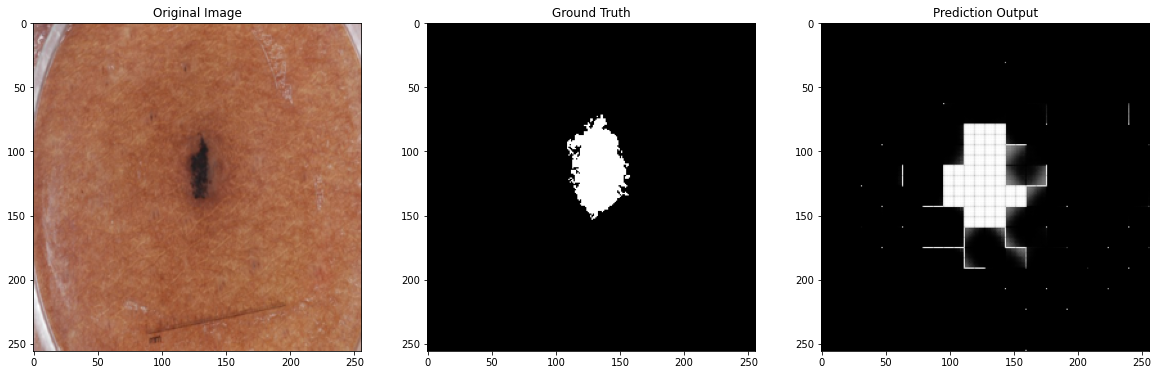

In [59]:
sampleImg=xTest[5].copy()
sampleImg=sampleImg.astype('uint8')
ysampleImg=yTest[5].copy()
ysampleImg=ysampleImg.astype('uint8')
img_pred2 = pretrainedFCN.predict(xTest[5].reshape(1,256,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(sampleImg)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(ysampleImg, plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)


plt.imshow(img_pred2.reshape(256, 256), plt.cm.binary_r)
plt.title('Prediction Output')
plt.show()

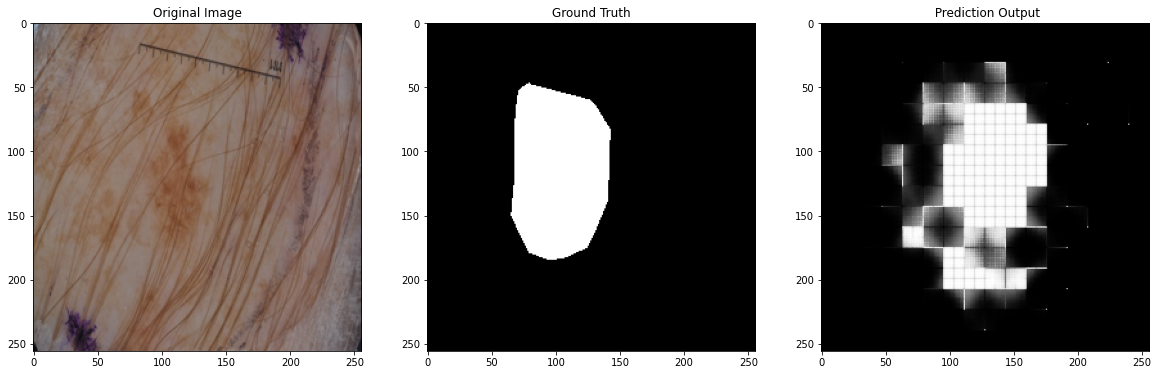

In [60]:
sampleImg=xTest[150].copy()
sampleImg=sampleImg.astype('uint8')
ysampleImg=yTest[150].copy()
ysampleImg=ysampleImg.astype('uint8')
img_pred2 = pretrainedFCN.predict(xTest[150].reshape(1,256,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(sampleImg)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(ysampleImg, plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)


plt.imshow(img_pred2.reshape(256, 256), plt.cm.binary_r)
plt.title(' Prediction Output')
plt.show()

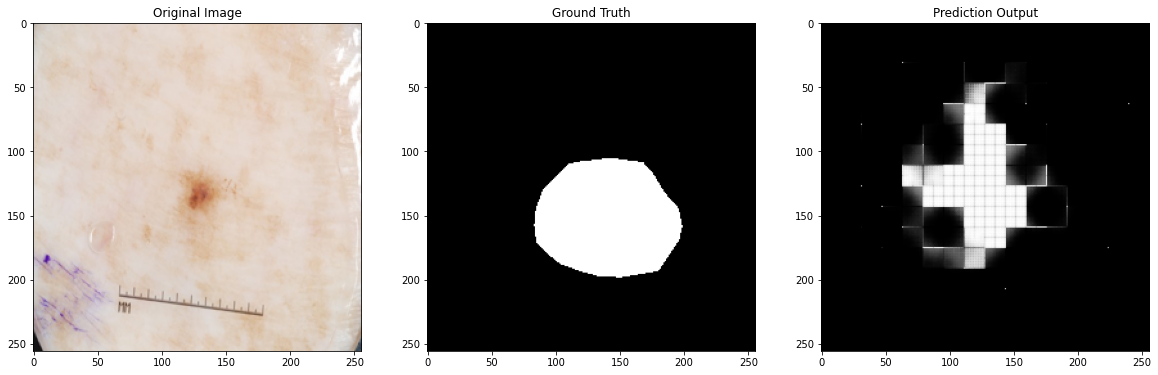

In [61]:
sampleImg=xTest[114].copy()
sampleImg=sampleImg.astype('uint8')
ysampleImg=yTest[114].copy()
ysampleImg=ysampleImg.astype('uint8')
img_pred2 = pretrainedFCN.predict(xTest[114].reshape(1,256,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(sampleImg)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(ysampleImg, plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)


plt.imshow(img_pred2.reshape(256, 256), plt.cm.binary_r)
plt.title('Prediction Output')
plt.show()

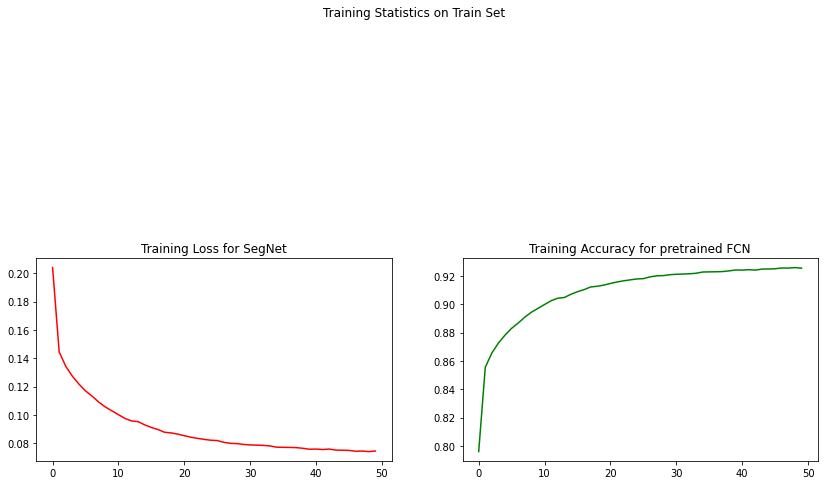

In [64]:
plt.figure(figsize=(14, 35))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(8,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Training Loss for SegNet')
plt.subplot(8,2,2)
plt.plot(hist.history['iou'], 'green')
plt.title('Training Accuracy for pretrained FCN')


plt.show()

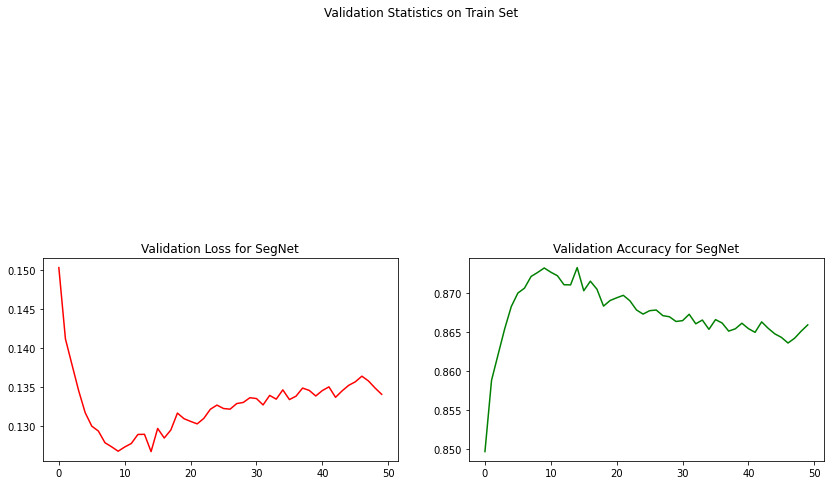

In [66]:
plt.figure(figsize=(14, 35))
plt.suptitle('Validation Statistics on Train Set')
plt.subplot(8,2,1)
plt.plot(hist.history['val_loss'], 'red')
plt.title('Validation Loss for SegNet')
plt.subplot(8,2,2)
plt.plot(hist.history['val_iou'], 'green')
plt.title('Validation Accuracy for SegNet')

plt.show()